In [1]:
"""
A TS adapter for using a GNN to predict TS guesses for isomerization reactions.
Citation: Pattanaik, L.; Ingraham, J.; Grambow, C.; Green, W. H. 2020.
Original published GNN used TensorFlow 1.4 and Python 2.7
This adapter uses the same architecture translated into PyTorch and Python 3.7
"""

'\nA TS adapter for using a GNN to predict TS guesses for isomerization reactions.\nCitation: Pattanaik, L.; Ingraham, J.; Grambow, C.; Green, W. H. 2020.\nOriginal published GNN used TensorFlow 1.4 and Python 2.7\nThis adapter uses the same architecture translated into PyTorch and Python 3.7\n'

In [2]:
from arc.species.species import ARCSpecies, enumerate_bonds
from arc.reaction import ARCReaction
from arc.plotter import draw_structure, plot_3d_mol_as_scatter

from rdkit import Chem
from rdkit.Chem.rdchem import ChiralType
from rdkit.Chem import AllChem

In [5]:
# We normally don't define species using xyz (ARC will determine it),
# but here we'd like to make sure that atom ordering is the same.
# ARC will preserve the xyz atom order as well as the RMG Molecule object created from it.
# I also defined SMILES, but it's not necessary (used for isomorphism check with the preceived connectivity)
# The created RMG Molecule object (stored in spc.mol) is created with the same atom order as in the given xyz.

xyz1 = """
C       2.48681185    0.74219788    0.29129615
C       1.29524181    0.18715038   -0.40777838
C       1.46444739   -0.47980720   -1.73736780
C       0.16705606   -0.55907814   -2.54092821
C      -0.36446443    0.80716478   -2.95523113
O      -1.52380810    0.62255823   -3.75896487
H       2.16965544    1.37829949    1.12297519
H       3.09112758    1.35063778   -0.38769069
H       3.10507890   -0.06601540    0.69197818
H      -1.84750558    1.50817592   -3.99677266
H       0.40069838   -0.01072042    0.17544185
H       2.22318045    0.04927747   -2.32572179
H       1.83755199   -1.49649681   -1.56779399
H      -0.60479748   -1.09591403   -1.97441015
H       0.34025028   -1.16121577   -3.44207305
H       0.37976603    1.35391729   -3.54296385
H      -0.64345729    1.40814259   -2.08442448"""

xyz2 = """C      -2.46980163   -0.12577955    0.55549609
C      -1.31178104    0.17111718   -0.38385509
C      -1.31218791    1.63372953   -0.82856447
C      -0.14249660    1.92946952   -1.77612989
C      -0.14107412    3.41360663   -2.22873160
O       0.89700906    3.56663441   -3.03638466
H      -3.43036007    0.06844820    0.06770664
H      -2.41124229    0.49137146    1.45773236
H      -2.45027007   -1.17661693    0.86089972
H      -0.36855204   -0.06395850    0.12282599
H      -1.38205507   -0.48455267   -1.25954086
H      -2.25951647    1.86383944   -1.33106784
H      -1.24569851    2.28455893    0.05171502
H      -0.21648654    1.26397688   -2.64824672
H       0.79894922    1.68536973   -1.26325779
H      -0.16879119    4.00888836   -1.30213259
H      -1.14694094    3.60296809   -2.63627032"""

spc1 = ARCSpecies(label='4-pentynol', smiles='C[CH]CCCO', xyz=xyz1)
spc2 = ARCSpecies(label='pentane_1ox', smiles='CCCCC[O]', xyz=xyz2)

In [6]:
draw_structure(spc1.get_xyz())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [7]:
draw_structure(spc2.get_xyz())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
# check symbol order (doesn't guarantee that all C's and all H's are ordered correctly)
for atom1, atom2 in zip(spc1.mol.atoms, spc2.mol.atoms):
    if atom1.element.symbol != atom2.element.symbol:
        print('order is incorrect')
        break
else:
    print('symbol order between mol1 and mol2 is correct')

for atom1, symbol2 in zip(spc1.mol.atoms, spc2.get_xyz()['symbols']):
    if atom1.element.symbol != symbol2:
        print('order is incorrect')
        break
else:
    print('symbol order between mol1 and xyz2 is correct')  

symbol order between mol1 and mol2 is correct
symbol order between mol1 and xyz2 is correct


In [9]:
# We normally don't define species using xyz (ARC will determine it),
# but here we'd like to make sure that atom ordering is the same.
# ARC will preserve the xyz atom order as well as the RMG Molecule object created from it.
# I also defined SMILES, but it's not necessary (used for isomorphism check with the preceived connectivity)
# The created RMG Molecule object (stored in spc.mol) is created with the same atom order as in the given xyz.

xyz1 = """C      -1.3087    0.0068    0.0318
C       0.1715   -0.0344    0.0210
N       0.9054   -0.9001    0.6395
O       2.1683   -0.5483    0.3437
N       2.1499    0.5449   -0.4631
N       0.9613    0.8655   -0.6660
H      -1.6558    0.9505    0.4530
H      -1.6934   -0.0680   -0.9854
H      -1.6986   -0.8169    0.6255"""

xyz2 = """C -1.0108   -0.0114   -0.0610
C       0.4780    0.0191    0.0139
N       1.2974   -0.9930    0.4693
O       0.6928   -1.9845    0.8337
N       1.7456    1.9701   -0.6976
N       1.1642    1.0763   -0.3716
H      -1.4020    0.9134   -0.4821
H      -1.3327   -0.8499   -0.6803
H      -1.4329   -0.1554    0.9349"""

# spc1 = ARCSpecies(label='r1', smiles='[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8])[H:9]', xyz=xyz1)
r1 = ARCSpecies(label='r1', smiles='[H]C([H])([H])c1nnon1', xyz=xyz1)
p1 = ARCSpecies(label='p1', smiles='[C:1]([C:2]([N:3]=[O:4])=[N+:6]=[N-:5])([H:7])([H:8])[H:9]', xyz=xyz2)

In [10]:
# ARC cannot determine the multiplicity when using the atom-mapped SMILES so convert it
mol = Chem.MolFromSmiles("[C:1]([c:2]1[n:3][o:4][n:5][n:6]1)([H:7])([H:8])[H:9]")
mol = Chem.AddHs(mol)
[a.SetAtomMapNum(0) for a in mol.GetAtoms()]
smiles = Chem.MolToSmiles(mol)
smiles

'[H]C([H])([H])c1nnon1'

In [11]:
# check symbol order (doesn't guarantee that the atoms are ordered correctly)
# this is a necessary, but not sufficient condition
for atom1, atom2 in zip(spc1.mol.atoms, spc2.mol.atoms):
    if atom1.element.symbol != atom2.element.symbol:
        print('order is incorrect')
        break
else:
    print('symbol order between mol1 and mol2 is correct')

for atom1, symbol2 in zip(spc1.mol.atoms, spc2.get_xyz()['symbols']):
    if atom1.element.symbol != symbol2:
        print('order is incorrect')
        break
else:
    print('symbol order between mol1 and xyz2 is correct')  

symbol order between mol1 and mol2 is correct
symbol order between mol1 and xyz2 is correct


In [12]:
draw_structure(r1.get_xyz())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [13]:
draw_structure(p1.get_xyz())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

ARC is instantiated with a list of ARCReaction objects

```
species = list()
reactions = list()

species.append(ARCSpecies(label='ethanol', yml_path='yml/ethanol.yml'))
species.append(ARCSpecies(label='OH', yml_path='yml/OH.yml'))
species.append(ARCSpecies(label='o_ethanol_rad', yml_path='yml/o_ethanol_rad.yml'))
species.append(ARCSpecies(label='H2O', yml_path='yml/H2O.yml'))

species.append(ARCSpecies(label='TS', is_ts=True, yml_path='yml/ethanol + OH = o_ethanol_rad + H2O.yml'))

reactions.append(ARCReaction(label='ethanol + OH <=> o_ethanol_rad + H2O', ts_label='TS', ts_methods=[]))


job_types = {'conformers': True, 'opt': True, 'fine_grid': False, 'freq': True, 'bde': False,
             'sp': True, 'rotors': False, 'irc': False}

arc = arc.ARC(project='rxn_tst',
               species=species,
               reactions=reactions,
               job_types=job_types,
              )
arc.execute()
```

In [14]:
# ARC is instatiated with 
reactions = list()
rxn = ARCReaction(label='r1 <=> p1', ts_methods=['gcn_isomerizaton'])
rxn.r_species = [r1]
rxn.p_species = [p1]
reactions.append(rxn)


In [15]:
r1.get_xyz()

{'symbols': ('C', 'C', 'N', 'O', 'N', 'N', 'H', 'H', 'H'),
 'isotopes': (12, 12, 14, 16, 14, 14, 1, 1, 1),
 'coords': ((-1.3087, 0.0068, 0.0318),
  (0.1715, -0.0344, 0.021),
  (0.9054, -0.9001, 0.6395),
  (2.1683, -0.5483, 0.3437),
  (2.1499, 0.5449, -0.4631),
  (0.9613, 0.8655, -0.666),
  (-1.6558, 0.9505, 0.453),
  (-1.6934, -0.068, -0.9854),
  (-1.6986, -0.8169, 0.6255))}

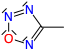

In [16]:
r1.mol

In [22]:
import sys
sys.path.append("/Users/kevin/Documents/Green_Lab/RMG/ts_gen_v2/")

In [23]:
from model.G2C import G2C

**Force the user to clone `ts_gen_v2` into the same directory level as ARC**

In [37]:
import torch
from torch_geometric.data import DataLoader
import yaml
import os
import copy

from ts_gen_v2_arc.arc_featurization import featurization
from model.common import ts_gen_v2_path

In [40]:
# create torch data loader
data_list = list()
ts_xyz_dict_list = list()
for reaction in reactions:
    data = featurization(reaction)
    data_list.append(data)
    
    # copy the reactant xyz dictionary since the atom symbols and isotopes will be identical in the TS
    # the YS xyz coordinates will be updated updated with those output by the GCN
    ts_xyz_dict = copy.deepcopy(reaction.r_species[0].get_xyz())
    ts_xyz_dict_list.append(ts_xyz_dict)

loader = DataLoader(data_list, batch_size=16)

In [53]:
reaction.label

'r1 <=> p1'

In [39]:
ts_xyz_dict_list

[{'symbols': ('C', 'C', 'N', 'O', 'N', 'N', 'H', 'H', 'H'),
  'isotopes': (12, 12, 14, 16, 14, 14, 1, 1, 1),
  'coords': ((-1.3087, 0.0068, 0.0318),
   (0.1715, -0.0344, 0.021),
   (0.9054, -0.9001, 0.6395),
   (2.1683, -0.5483, 0.3437),
   (2.1499, 0.5449, -0.4631),
   (0.9613, 0.8655, -0.666),
   (-1.6558, 0.9505, 0.453),
   (-1.6934, -0.068, -0.9854),
   (-1.6986, -0.8169, 0.6255))}]

In [41]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# define paths to model parameters and state dictionary
yaml_file_name = os.path.join(ts_gen_v2_path, 'best_model', 'model_paramaters.yml')
state_dict = os.path.join(ts_gen_v2_path, 'best_model', 'epoch_95_state_dict')

# create the network with the best architecture from hyperopt and load the corresponding best weights
with open(yaml_file_name, 'r') as f:
    content = yaml.load(stream=f, Loader=yaml.FullLoader)
model = G2C(**content).to(device)
model.load_state_dict(torch.load(state_dict, map_location=device))
model.eval()
print()

In [51]:
data.mols

AttributeError: 'Batch' object has no attribute 'mols'

In [49]:
coords_list = list()
for i, data in enumerate(loader):
    print(data)
    data = data.to(device)
    print(data)
    out, mask = model(data)  # out is distance matrix. mask is matrix of 1s with 0s along diagonal
    print(data)
    # extract xyz coordinates
    # shape of data.coords is (batch_size, n_atoms, 3). Each batch entry holds 1 TS guess
    for batch in data.coords:
        coords = batch.double().cpu().detach().numpy().tolist()
        ts_guess_coords = tuple()
        for atom in coords:  # range(coords.shape[0]):
            # unpack values and convert to immutable tuple
            x, y, z = atom
            coord = (x, y, z)
            ts_guess_coords += (coord,)
        ts_xyz_dict_list[i]['coords'] = ts_guess_coords
ts_xyz_dict_list

Batch(batch=[9], edge_attr=[72, 2], edge_index=[2, 72], x=[9, 7])
Batch(batch=[9], edge_attr=[72, 2], edge_index=[2, 72], x=[9, 7])
Batch(batch=[9], coords=[1, 9, 3], edge_attr=[72, 2], edge_index=[2, 72], x=[9, 7])


[{'symbols': ('C', 'C', 'N', 'O', 'N', 'N', 'H', 'H', 'H'),
  'isotopes': (12, 12, 14, 16, 14, 14, 1, 1, 1),
  'coords': ((1.137328028678894, -0.21724112331867218, -0.06502946466207504),
   (-0.36193403601646423, 0.13385573029518127, 0.1266731470823288),
   (-1.2777485847473145, -0.738975465297699, 0.6415482759475708),
   (-1.8167273998260498, -1.20418119430542, -0.20070095360279083),
   (-1.9931057691574097, 1.0558290481567383, -0.7061572670936584),
   (-1.061540126800537, 0.9158233404159546, -0.5742824077606201),
   (1.5789681673049927, 0.7405375242233276, -0.12110333889722824),
   (1.3693119287490845, -0.7896703481674194, -0.8954232931137085),
   (1.3829143047332764, -0.786466121673584, 0.7622897028923035))}]

In [48]:
mask

tensor([[[0., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 0., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 0., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 0., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 0., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 0., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 0., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 0., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 0.]]])

In [45]:
r1.get_xyz()

{'symbols': ('C', 'C', 'N', 'O', 'N', 'N', 'H', 'H', 'H'),
 'isotopes': (12, 12, 14, 16, 14, 14, 1, 1, 1),
 'coords': ((-1.3087, 0.0068, 0.0318),
  (0.1715, -0.0344, 0.021),
  (0.9054, -0.9001, 0.6395),
  (2.1683, -0.5483, 0.3437),
  (2.1499, 0.5449, -0.4631),
  (0.9613, 0.8655, -0.666),
  (-1.6558, 0.9505, 0.453),
  (-1.6934, -0.068, -0.9854),
  (-1.6986, -0.8169, 0.6255))}

In [46]:
p1.get_xyz()

{'symbols': ('C', 'C', 'N', 'O', 'N', 'N', 'H', 'H', 'H'),
 'isotopes': (12, 12, 14, 16, 14, 14, 1, 1, 1),
 'coords': ((-1.0108, -0.0114, -0.061),
  (0.478, 0.0191, 0.0139),
  (1.2974, -0.993, 0.4693),
  (0.6928, -1.9845, 0.8337),
  (1.7456, 1.9701, -0.6976),
  (1.1642, 1.0763, -0.3716),
  (-1.402, 0.9134, -0.4821),
  (-1.3327, -0.8499, -0.6803),
  (-1.4329, -0.1554, 0.9349))}